# Imports

In [1]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch 
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'torch {torch.__version__}')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from torch.utils.data import TensorDataset
import optuna
from torch import nn

Package versions: 

numpy 1.23.5
pandas 1.5.3
scikit-learn 1.2.1
torch 2.0.0+cu117


C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading in Data

In [2]:
bank = pd.read_csv('clean_store.csv')
predictors = list(bank.columns[:-1])
bank = bank[predictors]

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()



X_train = train.loc[:, train.columns!='resp']
X_valid = valid.loc[:, test.columns!='resp']
X_test = test.loc[:, test.columns!='resp']

# predictors = list(X_train.columns)

y_train = train['resp']
y_valid = valid['resp']
y_test = test['resp']

# converting 0s to -1
# y_train = y_train.replace(0, -1)
# y_valid = y_valid.replace(0, -1)
# y_test = y_test.replace(0, -1)

# Encoding the data

# Neural network helper functions

In [3]:
def predict(net, X):
    
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Move data to device
    X_g = X.to(device)
    
    # Put model on evaluation mode (it makes no difference but needed in some cases)
    net.eval()
    
    # Disable gradient computation
    with torch.no_grad():
        
        # Predicted probabilities 
        # the .cpu().detach() part transfers the result to the cpu
        output  = net(X_g).cpu().detach()
    
    return output # the output is a tensor

In [4]:
import time

def train_net(model, input_size, trainloader, validset, trial=None, num_epochs = 5 , lr = 1e-3):
    
    # Get device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if trial == None:
        # Instantiate model and move to device
        net = model(input_size).to(device)
    else:
        net = model(input_size, trial).to(device)
    
    # Loss function
    loss_fn = nn.BCELoss() # binary cross-entropy loss, assumes that the output of the network is a probability
    
    # Instantiate optimiser
    # Adam is a variant of SGD that often works well for training neural networks
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimiser = torch.optim.Adam(net.parameters(), lr = lr) 
    
    # Addding a learning rate scheduler to improve training
    # Adam + OneCycleLR is a good default for many problems
    # Learn more: https://sgugger.github.io/the-1cycle-policy.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr = lr, 
                                                   steps_per_epoch=len(trainloader), epochs = num_epochs,
                                                   three_phase=True)
    # Number of training samples
    num_samples = len(trainloader.dataset)
    
    # Initialise table to track training
    table =  init_training_table(num_epochs)
    
    # Training loop
    print('Running first epoch')
    for epoch in range(num_epochs):
        
        # Make sure that the model is on training mode
        net.train()
        
        # Initialise timer
        epoch_start = time.time()
        
        # Initialise metric
        train_loss = 0.0
        
        # Iterate over minibatches
        for X, y in trainloader:

            # Move minibatch to device
            X_g = X.to(device)
            y_g = y.to(device)

            # Reset the gradient
            optimiser.zero_grad()

            # Compute predictions
            output = net(X_g)

            # Evaluate cost function
            loss = loss_fn(output, y_g)

            # Compute gradient 
            loss.backward()

            # Update parameters
            optimiser.step()
            
            # Update scheduler
            scheduler.step()
            
            # Keep track of the training loss
            l = loss.cpu().detach().numpy()
            train_loss +=  l*(len(y)/num_samples)
  
        # Epoch length
        duration = time.time() - epoch_start 
        
        # Display metrics
        if trial == None:
            table.iloc[epoch, 1] = np.round(10*train_loss, 3)
            table =  update_training_table(table, net, validset, epoch, duration)
    
    return net

In [5]:
# auxiliary code

from torch.nn import functional as F
from sklearn.metrics import recall_score, average_precision_score

def evaluate(net, validset):
    
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Set model to evaluation mode (not necessary here but required in general)
    net.eval()
    
    # Get input and target
    X, y = validset[:]
        
    # Predicted probabilities 
    output = predict(net, X)
        
    # Validation loss
    loss = F.binary_cross_entropy(output, y).item()
    
    # Convert output to numpy
    y_prob = output.numpy()
     
    # Classification using the decision threshold
    tau = 1/20
    y_pred = (y_prob > tau).astype(int)
    
    # Validation metrics
    recall = recall_score(y_valid, y_pred)
    average_precision = average_precision_score(y_valid, y_prob)
    
    return loss, recall, average_precision 


from IPython.display import clear_output
from IPython.display import display, HTML

def init_training_table(num_epochs):
    table = pd.DataFrame(np.arange(1, num_epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['valid loss'] = 0.0
    table['valid recall'] = 0.0
    table['valid average precision'] = 0.0
    table['time'] = ''
    return table

def update_training_table(table, net, validset, epoch, duration):
    
    # Run evaluation function to get validation metrics
    valid_loss, valid_recall, valid_ave_precision = evaluate(net, validset)
        
    # Update table
    table.iloc[epoch, 2] = np.round(10*valid_loss, 3)
    print(valid_recall)
    table.iloc[epoch, 3] = np.round(valid_recall, 3)
    table.iloc[epoch, 4] = np.round(valid_ave_precision, 3)
     
    # Epoch length   
    if duration > 3600:
        table.iloc[epoch, 5] = time.strftime('%H:%M:%S', time.gmtime(duration))
    else:
        table.iloc[epoch, 5] = time.strftime('%M:%S', time.gmtime(duration))
        
    clear_output(wait=True)
    display(HTML(table.iloc[:epoch+1, :].to_html(index=False)))
    
    return table

# Testing the different encodings on a simple neural network

In [6]:
def test_encodings(algo, variables):

    results_df_dic = {}
    for x in nominal:

        rows = ['One-Hot encoding', 'Target encoder', 'Leave-one-out encoder', 
        'GLMM encoder', 'CatBoost encoder', 'ordinal encoder']

        columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision']

        results = pd.DataFrame(0.0, columns=columns, index=rows)


        y_prob = np.zeros((len(y_valid), len(rows)))
        for i in range(len(rows)):
            if i == 5 and x != 'education':
                continue
            feature = []
            if i==0:
                feature = variables + globals()['%s_OneHot' % x]
            elif i==1: 
                feature = variables + [x+'TE'] 
            elif i==2:
                feature = variables + [x+'LeaveOneOut']
            elif i==3: 
                feature = variables + [x+'GLMM']
            elif i==4: 
                feature = variables + [x+'CatBoost']  
            if x == 'education':
                if i==5:
                    feature = variables + ['educationOrdinal']

            X_train = train[feature].copy()
            X_valid = valid[feature].copy()
            
            trainset  = TensorDataset(torch.from_numpy(X_train.to_numpy()).float(), torch.from_numpy(y_train).float())
            validset  = TensorDataset(torch.from_numpy(X_valid.to_numpy()).float(), torch.from_numpy(y_valid).float())
            testset = TensorDataset(torch.from_numpy(X_test.to_numpy()).float(), torch.from_numpy(y_valid).float())
            
            trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)
            
            model = algo
            
            model.train(X_train, y_train)

            # validation set predictions

            y_prob[:, i] = model.predict(X_valid)

            lfp = 1
            lfn = 19
            tau = lfp/(lfp+lfn)

            y_prob[:, i][y_prob[:,i] < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
            y_prob[:, i][y_prob[:,i] > 1- 1e-5] =  1- 1e-5

            y_pred = (y_prob[:,i] > tau).astype(int)
            # y_pred = model.predict(X_valid)

            tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

            results.iloc[i,0] =  log_loss(y_valid, y_prob[:,i])   # Cross entropy
            results.iloc[i,1] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
            results.iloc[i,2] =  roc_auc_score(y_valid, y_prob[:,i])   # AUC
            results.iloc[i,3] =  tp/(tp+fn)   # Sensitivity 
            results.iloc[i,4] =  tn/(tn+fp)   # Specificity	
            results.iloc[i,5] =  precision_score(y_valid, y_pred)   # Precision



        if x not in results_df_dic:
            results_df_dic[x] = results
    return results_df_dic

In [6]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        
        self.feedforward = nn.Sequential(            
            nn.Linear(input_size, 40),            
            nn.ReLU(),                       
            nn.Linear(40, 40),
            nn.ReLU(),  
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
            nn.Sigmoid()
        )                        


    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

# Converting data to Dataset and Dataloader for pytorch

In [7]:

trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
testset = TensorDataset(torch.from_numpy(X_test.copy().to_numpy()).float(), torch.from_numpy(y_test.to_numpy()).float())


# Testing different encodings

In [8]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, log_loss
from torch.nn import functional as F
from sklearn.metrics import recall_score, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from torch.utils.data import DataLoader

In [9]:

feature_for_nn = X_train.columns

def get_model_performance(feature_list, algo_name):

    X_train = train[feature_list]
    X_valid = valid[feature_list]
    y_prob = np.zeros(len(y_valid))
    
    trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
    validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
    trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)

    mlp = train_net(NeuralNetwork, len(X_train.columns), trainloader, validset, num_epochs = 1500, lr = 3e-4)

    X = validset[:][0]
    y_prob = predict(mlp, X).numpy()

    lfp = 1
    lfn = 19
    tau = lfp/(lfp+lfn)

    y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
    y_prob[y_prob > 1- 1e-5] =  1- 1e-5

    y_pred = (y_prob > tau).astype(int)
    # y_pred = model.predict(X_valid)

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision']

    results = pd.DataFrame(0.0, columns=columns, index=[algo_name])

    results.iloc[:,0] =  log_loss(y_valid, y_prob)   # Cross entropy
    results.iloc[:,1] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
    results.iloc[:,2] =  roc_auc_score(y_valid, y_prob)   # AUC
    results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
    results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
    results.iloc[:,5] =  precision_score(y_valid, y_pred)   # Precision
    return results, mlp


results, fitted_model = get_model_performance(feature_for_nn, "Neural network")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

KeyboardInterrupt: 

# Confusion matrix

In [10]:
import seaborn as sns

In [11]:
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total subscribed Transactions: ', np.sum(cm[1]))
    
    print('total loss from loss matrix:', cm[1][0] * 19 + cm[0][1])

In [12]:
def display_confusion_mat(feature_list):
    X_valid = valid[feature_list]
    

    lfp = 1
    lfn = 19
    tau = lfp/(lfp+lfn)

    # y_pred = decision_tree.predict(X_valid[feature_for_dt])

    y_prob = predict(fitted_model, validset[:][0]).numpy()

    y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
    y_prob[y_prob > 1- 1e-5] =  1- 1e-5

    y_pred = (y_prob > tau).astype(int)
    # y_pred = decision_tree.predict(valid[feature_for_dt])

    plot_cm(y_valid, y_pred)

display_confusion_mat(feature_for_nn)

NameError: name 'fitted_model' is not defined

(True Negatives):  2469
(False Positives):  2949
(False Negatives):  59
(True Positives):  1046
Total subscribed Transactions:  1105
total loss from loss matrix: 4070


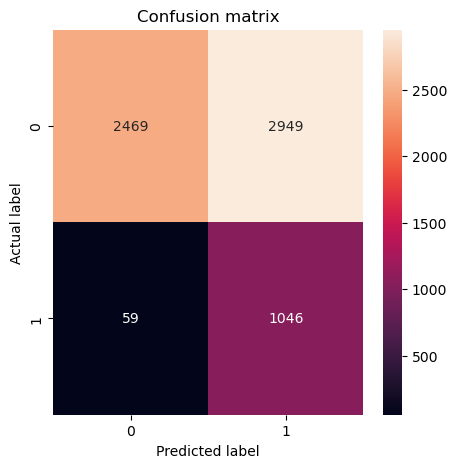

In [14]:

lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])

y_prob = predict(fitted_model, testset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_test, y_pred)

# Using optuna to optimize number of layers and neurons

In [15]:
class NeuralNetworkBuilder(nn.Module):
    
    def __init__(self, input_size, trial):
        super(NeuralNetworkBuilder, self).__init__()
        
        self.modules = []
        self.neurons = []
        
        hidden_layers = trial.suggest_int('num_layers', 1, 7)
        
        for i in range(hidden_layers):
            activation_func = trial.suggest_categorical(f'activation_func_{i}', ['relu', 'leakyrelu', 'tanh', 'sigmoid'])
            
            if activation_func == "relu":
                self.activation_func = nn.ReLU()
            elif activation_func == "leakyrelu":
                self.activation_func = nn.LeakyReLU()
            elif activation_func == "tanh":
                self.activation_func = nn.Tanh()
            elif activation_func == "sigmoid":
                self.activation_func = nn.Sigmoid()
                
            neurons = trial.suggest_int(f'num_neurons_{i}', 1, 40)
            self.neurons.append(neurons)
            
            if i == 0:
                self.modules.append(nn.Linear(input_size, neurons))
                
            else:
                self.modules.append(nn.Linear(self.neurons[i - 1], neurons))
            self.modules.append(self.activation_func)
        
        self.modules.append(nn.Linear(self.neurons[-1], 1))
        self.modules.append(nn.Sigmoid())
        
        self.feedforward = nn.Sequential(*self.modules)                        


    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

In [15]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

X_train = train[feature_for_nn]
X_valid = valid[feature_for_nn]

trainset  = TensorDataset(torch.from_numpy(X_train.copy().to_numpy()).float(), torch.from_numpy(y_train.to_numpy()).float())
validset  = TensorDataset(torch.from_numpy(X_valid.copy().to_numpy()).float(), torch.from_numpy(y_valid.to_numpy()).float())
trainloader = DataLoader(trainset, batch_size = 1024, shuffle=True)

def objective(trial):
       
    model = train_net(NeuralNetworkBuilder, len(feature_for_nn), trainloader, validset, trial=trial, num_epochs = 200, lr = 5e-4)
  
    lfp = 1
    lfn = 19
    tau = lfp/(lfp+lfn)

    # y_pred = decision_tree.predict(X_valid[feature_for_dt])

    y_prob = predict(model, validset[:][0]).numpy()
    roc = roc_auc_score(y_valid, y_prob)
    
    return roc

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 2000) 

[I 2023-05-25 00:12:15,997] A new study created in memory with name: no-name-2b71f84b-3501-416a-ab00-e77aac035391
[W 2023-05-25 00:12:15,999] Trial 0 failed with parameters: {} because of the following error: NameError("name 'NeuralNetworkBuilder' is not defined").
Traceback (most recent call last):
  File "C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ericx\AppData\Local\Temp\ipykernel_16256\590768334.py", line 13, in objective
    model = train_net(NeuralNetworkBuilder, len(feature_for_nn), trainloader, validset, trial=trial, num_epochs = 200, lr = 5e-4)
NameError: name 'NeuralNetworkBuilder' is not defined
[W 2023-05-25 00:12:16,001] Trial 0 failed with value None.


NameError: name 'NeuralNetworkBuilder' is not defined

In [17]:
params = study.best_params
params

{'num_layers': 1, 'activation_func_0': 'relu', 'num_neurons_0': 23}

In [18]:
best_nn_modules = [*params]

In [16]:
class NeuralNetwork_No_Class_Balancing(nn.Module):
    
    def __init__(self, input_size):
        super(NeuralNetwork_No_Class_Balancing, self).__init__()
        
        self.feedforward = nn.Sequential(            
            nn.Linear(input_size, 6),            
            nn.ReLU(),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )                        


    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

In [18]:
 mlp_no_class_balancing = train_net(NeuralNetwork_No_Class_Balancing, len(X_train.columns), trainloader, validset, num_epochs = 1000, lr = 5e-4)

AUC score:  0.8540844400691538
(True Negatives):  1156
(False Positives):  1366
(False Negatives):  19
(True Positives):  503
Total subscribed Transactions:  522
total loss from loss matrix: 1727


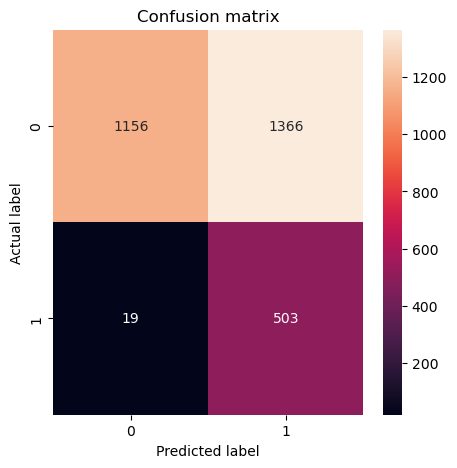

In [19]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])

y_prob = predict(mlp_no_class_balancing, validset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

print('AUC score: ', roc_auc_score(y_valid, y_prob))

y_pred = (y_prob > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_valid, y_pred)

AUC score:  0.8456495776605214
(True Negatives):  2439
(False Positives):  2979
(False Negatives):  46
(True Positives):  1059
Total subscribed Transactions:  1105
total loss from loss matrix: 3853


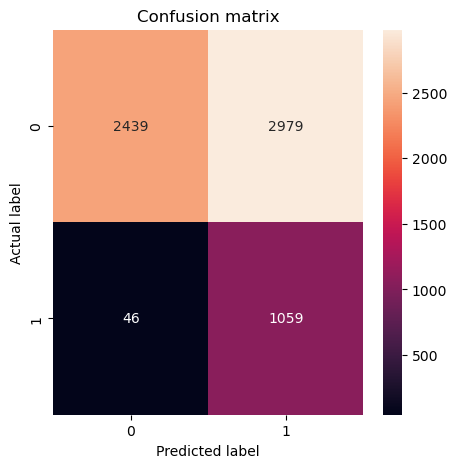

In [20]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])

y_prob = predict(mlp_no_class_balancing, testset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

print('AUC score: ', roc_auc_score(y_test, y_prob))

y_pred = (y_prob > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_test, y_pred)

In [22]:
from sklearn.metrics import f1_score

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'f1-score']

results = pd.DataFrame(0.0, columns=columns, index=['mlp'])

results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
results.iloc[:,6] =  f1_score(y_test, y_pred)

In [24]:
display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

Cross-entropy  Error Rate      AUC  Sensitivity  Specificity  Precision  \
mlp        0.33551     0.46374  0.84565      0.95837      0.45017    0.26226   

     f1-score  
mlp   0.41182

# class weight approach

In [23]:
from torch.utils.data import WeightedRandomSampler

In [24]:
for x,y in trainset:
    print(x)
    print(y)

tensor([8.5032e+04, 1.3000e+01, 8.6727e+02, 1.0000e+00, 6.6710e+01, 1.6000e+01,
        4.7000e-01, 2.0000e-02, 4.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5000e-01, 0.0000e+00, 4.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.8930e+02, 7.7970e+01,
        0.0000e+00, 2.9800e+00, 0.0000e+00, 3.3297e+02, 0.0000e+00, 5.8000e-01,
        1.6000e+01, 7.0000e+02, 5.3840e+01, 2.1000e-01, 9.0000e+00, 3.0000e+00,
        4.2000e+01, 2.0000e+00, 0.0000e+00, 9.0000e+00, 5.0000e+00, 5.5560e+01,
        2.5340e+01, 1.3460e+01, 2.2000e+01, 3.6000e-01])
tensor(0.)
tensor([7.1090e+03, 2.0000e+00, 1.3854e+02, 1.0000e+00, 6.9270e+01, 1.6000e+01,
        1.5000e-01, 0.0000e+00, 0.0000e+00, 1.6000e-01, 0.0000e+00, 1.2000e-01,
        1.2000e-01, 1.3000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.3660e+01, 5.4880e+01,
        0.0000e+00, 1.3854e+02, 0.0000e+00, 1.3854e+

tensor([4.7591e+04, 1.0000e+00, 1.1300e+02, 0.0000e+00, 1.1300e+02, 1.1000e+01,
        5.6000e-01, 0.0000e+00, 0.0000e+00, 2.4000e-01, 0.0000e+00, 0.0000e+00,
        1.8000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1300e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4000e-01,
        1.3000e+01, 3.0200e+02, 3.0200e+02, 2.8000e-01, 3.0000e+00, 0.0000e+00,
        5.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        4.1560e+01, 3.0200e+02, 3.5000e+01, 0.0000e+00])
tensor(0.)
tensor([5.8201e+04, 2.0000e+01, 1.6027e+03, 1.0000e+00, 8.0130e+01, 1.6000e+01,
        3.2000e-01, 1.0000e-02, 0.0000e+00, 4.0000e-02, 1.3000e-01, 0.0000e+00,
        1.4000e-01, 7.0000e-02, 1.0000e-02, 0.0000e+00, 3.0000e-02, 0.0000e+00,
        4.0000e-02, 6.2590e-03, 0.0000e+00, 0.0000e+00, 1.1869e+03, 4.1574e+02,
        0.0000e+00, 4.6344e+02, 3.2107e+02, 8.1967e+

tensor(0.)
tensor([7.5503e+04, 4.0000e+00, 1.7799e+02, 0.0000e+00, 4.4490e+01, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e-02, 1.8000e-01, 0.0000e+00,
        0.0000e+00, 8.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.7000e-01, 0.0000e+00, 0.0000e+00, 1.7799e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.8000e-01,
        9.0000e+00, 3.6400e+02, 9.1000e+01, 0.0000e+00, 8.0000e+00, 0.0000e+00,
        9.0000e+00, 2.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1650e+01, 9.1000e+01, 4.0000e+00, 2.0700e+00])
tensor(0.)
tensor([4.8910e+04, 5.0000e+00, 1.0260e+03, 1.0000e+00, 2.0520e+02, 1.6000e+01,
        2.0000e-02, 0.0000e+00, 0.0000e+00, 3.0000e-02, 3.6000e-01, 2.0000e-01,
        1.0000e-02, 6.0000e-02, 0.0000e+00, 9.0000e-02, 0.0000e+00, 1.0000e-02,
        6.4980e-03, 0.0000e+00, 7.0000e-02, 0.0000e+00, 8.6601e+02, 1.6000e+02,
        0.0000e+00, 4.4576e+02, 4.4576e+0

tensor([7.8259e+04, 1.0000e+00, 3.4298e+02, 0.0000e+00, 3.4298e+02, 1.1000e+01,
        3.9000e-01, 0.0000e+00, 1.4000e-01, 0.0000e+00, 2.3000e-01, 0.0000e+00,
        0.0000e+00, 1.5000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4000e+01, 8.2990e+01, 2.3599e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4298e+02, 0.0000e+00, 6.7000e-01,
        8.0000e+00, 3.7600e+02, 3.7600e+02, 0.0000e+00, 6.0000e+00, 0.0000e+00,
        9.0000e+00, 3.0000e+00, 0.0000e+00, 7.0000e+00, 1.0000e+00, 1.4290e+01,
        2.6170e+01, 4.7000e+01, 2.0000e+00, 0.0000e+00])
tensor(0.)
tensor([3.7211e+04, 5.0000e+00, 8.5463e+02, 1.0000e+00, 1.7092e+02, 1.1000e+01,
        1.6000e-01, 2.0000e-02, 1.3000e-01, 1.2000e-01, 1.6000e-01, 6.0000e-02,
        7.0000e-02, 5.0000e-02, 0.0000e+00, 0.0000e+00, 1.3000e-01, 2.0000e-02,
        0.0000e+00, 8.8020e-03, 2.3000e-01, 0.0000e+00, 0.0000e+00, 7.7482e+02,
        7.9810e+01, 0.0000e+00, 0.0000e+00, 2.4980e+

tensor([6.0465e+04, 3.0000e+00, 1.9411e+02, 0.0000e+00, 6.4700e+01, 1.1000e+01,
        7.4000e-01, 1.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.5000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9980e+01, 1.4413e+02,
        0.0000e+00, 1.4413e+02, 0.0000e+00, 1.4413e+02, 4.9980e+01, 2.7000e-01,
        5.0000e+00, 6.6900e+02, 2.2300e+02, 2.4000e-01, 4.0000e+00, 0.0000e+00,
        9.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+01,
        5.8580e+01, 1.1150e+02, 1.0000e+01, 0.0000e+00])
tensor(0.)
tensor([4.3064e+04, 9.0000e+00, 4.7005e+02, 0.0000e+00, 5.2220e+01, 1.1000e+01,
        4.0000e-01, 4.0000e-02, 1.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-02, 5.0000e-02, 2.1000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-02, 2.0000e-02, 0.0000e+00, 0.0000e+00, 7.8000e+01, 3.9205e+02,
        0.0000e+00, 1.9580e+01, 0.0000e+00, 1.2356e+

tensor([6.0440e+04, 4.0000e+00, 2.9827e+02, 1.0000e+00, 7.4560e+01, 1.6000e+01,
        1.6000e-01, 6.0000e-02, 2.7000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.5000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7497e+02, 2.3300e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9827e+02, 0.0000e+00, 6.2000e-01,
        2.2000e+01, 5.0100e+02, 1.2525e+02, 1.1000e-01, 6.0000e+00, 1.0000e+00,
        1.6000e+01, 4.0000e+00, 0.0000e+00, 9.0000e+00, 2.0000e+00, 2.2220e+01,
        1.7410e+01, 4.1750e+01, 5.0000e+00, 4.2000e-01])
tensor(0.)
tensor([4.4060e+04, 4.0000e+00, 2.8596e+02, 0.0000e+00, 7.1490e+01, 1.1000e+01,
        4.0000e-01, 7.0000e-02, 0.0000e+00, 1.7000e-01, 2.7000e-01, 0.0000e+00,
        0.0000e+00, 6.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8596e+02,
        0.0000e+00, 6.0960e+01, 0.0000e+00, 6.0960e+

tensor([7.1270e+04, 7.0000e+00, 1.1839e+03, 0.0000e+00, 1.6913e+02, 1.1000e+01,
        3.3000e-01, 0.0000e+00, 0.0000e+00, 8.0000e-02, 8.0000e-02, 1.0000e-01,
        7.0000e-02, 7.0000e-02, 2.1000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.3255e+02,
        3.5137e+02, 7.4936e+02, 0.0000e+00, 7.4936e+02, 0.0000e+00, 5.9000e-01,
        1.8000e+01, 3.6900e+02, 5.2710e+01, 1.8000e-01, 1.0000e+01, 0.0000e+00,
        3.7000e+01, 2.0000e+00, 0.0000e+00, 9.0000e+00, 3.0000e+00, 3.3330e+01,
        1.9560e+01, 1.8450e+01, 1.0000e+01, 2.0000e-02])
tensor(0.)
tensor([5.3208e+04, 3.0000e+00, 3.1000e+02, 1.0000e+00, 1.0333e+02, 1.6000e+01,
        2.4000e-01, 0.0000e+00, 0.0000e+00, 9.0000e-02, 2.8000e-01, 1.7000e-01,
        0.0000e+00, 1.4000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.0000e-02, 0.0000e+00, 4.5000e-01, 0.0000e+00, 2.9200e+02, 1.8000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9000e+

tensor([4.5011e+04, 1.0000e+00, 1.8799e+02, 0.0000e+00, 1.8799e+02, 1.1000e+01,
        0.0000e+00, 5.0000e-02, 0.0000e+00, 0.0000e+00, 5.2000e-01, 3.1000e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-01, 0.0000e+00, 8.4000e-01, 0.0000e+00, 0.0000e+00, 1.8799e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.5000e-01,
        1.6000e+01, 2.8300e+02, 2.8300e+02, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0963e+02, 2.8300e+02, 1.1000e+01, 0.0000e+00])
tensor(0.)
tensor([3.4698e+04, 1.0000e+00, 1.4498e+02, 0.0000e+00, 1.4498e+02, 1.6000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2999e+02, 1.4990e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

tensor(0.)
tensor([3.3617e+04, 3.0000e+00, 3.0438e+02, 0.0000e+00, 1.0146e+02, 1.1000e+01,
        1.8000e-01, 0.0000e+00, 9.0000e-02, 0.0000e+00, 2.5000e-01, 1.3000e-01,
        4.0000e-02, 1.0000e-01, 1.3000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0438e+02,
        0.0000e+00, 2.1442e+02, 0.0000e+00, 3.0438e+02, 0.0000e+00, 2.9000e-01,
        3.0000e+00, 1.4600e+02, 4.8660e+01, 2.4000e-01, 8.0000e+00, 0.0000e+00,
        1.4000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5780e+01, 3.6500e+01, 2.4000e+01, 0.0000e+00])
tensor(0.)
tensor([3.2821e+04, 9.0000e+00, 6.3782e+02, 1.0000e+00, 7.0860e+01, 1.6000e+01,
        1.7000e-01, 3.0000e-02, 4.0000e-02, 1.9000e-01, 7.0000e-02, 0.0000e+00,
        1.8000e-01, 1.8000e-01, 5.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.1591e+02, 1.2191e+02,
        0.0000e+00, 1.3042e+02, 3.9500e+0

tensor([4.8167e+04, 1.0000e+00, 1.8300e+02, 0.0000e+00, 1.8300e+02, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4000e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.5000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.4000e-01, 0.0000e+00, 0.0000e+00, 1.8300e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9000e-01,
        1.3000e+01, 3.6200e+02, 3.6200e+02, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        7.9600e+01, 3.6200e+02, 1.0000e+00, 0.0000e+00])
tensor(0.)
tensor([3.2822e+04, 1.0000e+00, 9.3600e+01, 1.0000e+00, 9.3600e+01, 1.6000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.7000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.0000e-02, 0.0000e+00, 0.0000e+00, 8.8200e+01, 5.4000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

tensor(0.)
tensor([4.3231e+04, 1.0000e+00, 1.1300e+02, 0.0000e+00, 1.1300e+02, 1.1000e+01,
        8.6000e-01, 0.0000e+00, 0.0000e+00, 1.3000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.3000e-01, 0.0000e+00, 0.0000e+00, 1.1300e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e-01,
        1.6000e+01, 3.7100e+02, 3.7100e+02, 3.1000e-01, 2.0000e+00, 0.0000e+00,
        5.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        7.8730e+01, 9.2750e+01, 1.1000e+01, 0.0000e+00])
tensor(0.)
tensor([9.3230e+04, 6.0000e+00, 8.3396e+02, 0.0000e+00, 1.3899e+02, 1.6000e+01,
        1.4000e-01, 1.0000e-02, 0.0000e+00, 2.0000e-01, 3.3000e-01, 0.0000e+00,
        0.0000e+00, 2.4000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.5930e-03,
        4.0000e-02, 0.0000e+00, 2.3000e-01, 0.0000e+00, 7.3397e+02, 9.9990e+01,
        0.0000e+00, 4.1297e+02, 4.1297e+0

tensor(0.)
tensor([2.3842e+04, 3.0000e+00, 1.6496e+02, 0.0000e+00, 5.4980e+01, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 2.8000e-01, 0.0000e+00, 3.0000e-01, 2.5000e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0497e+02,
        5.9990e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9000e-01,
        1.9000e+01, 6.5500e+02, 2.1833e+02, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        5.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00,
        2.3990e+01, 1.3100e+02, 1.6000e+01, 1.8000e-01])
tensor(0.)
tensor([4.3611e+04, 1.0000e+00, 3.4698e+02, 0.0000e+00, 3.4698e+02, 1.6000e+01,
        3.4000e-01, 0.0000e+00, 0.0000e+00, 9.0000e-02, 0.0000e+00, 2.2000e-01,
        1.1000e-01, 1.7000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7698e+02, 1.7000e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor([1.0598e+04, 3.0000e+00, 1.2142e+02, 1.0000e+00, 4.0470e+01, 1.6000e+01,
        2.4000e-01, 0.0000e+00, 0.0000e+00, 2.3000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.8000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.5180e+01, 2.6240e+01,
        0.0000e+00, 1.3990e+01, 0.0000e+00, 1.3990e+01, 0.0000e+00, 0.0000e+00,
        1.4000e+01, 4.0000e+02, 1.3333e+02, 5.5000e-01, 5.0000e+00, 2.0000e+00,
        9.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00, 1.0000e+00, 1.6670e+01,
        2.6710e+01, 4.4440e+01, 1.0000e+00, 1.4000e-01])
tensor(0.)
tensor([6.3857e+04, 3.0000e+00, 1.5343e+02, 0.0000e+00, 5.1140e+01, 1.1000e+01,
        2.0000e-01, 0.0000e+00, 2.9000e-01, 0.0000e+00, 1.8000e-01, 3.1000e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5343e+02,
        0.0000e+00, 7.6960e+01, 0.0000e+00, 7.6960e+

tensor(1.)
tensor([9.5648e+04, 9.0000e+00, 1.4747e+02, 0.0000e+00, 1.6380e+01, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 2.0000e-02, 0.0000e+00, 4.1000e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4747e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e-01,
        4.0000e+00, 2.5000e+02, 2.7770e+01, 2.0000e-01, 7.0000e+00, 0.0000e+00,
        1.1000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.7870e+01, 1.5620e+01, 1.1000e+01, 8.9000e-01])
tensor(0.)
tensor([3.4685e+04, 2.0000e+00, 3.2900e+02, 1.0000e+00, 1.6450e+02, 1.6000e+01,
        1.7000e-01, 7.0000e-02, 0.0000e+00, 0.0000e+00, 4.5000e-01, 0.0000e+00,
        0.0000e+00, 2.8000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7000e+02, 5.9000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+0

tensor([8.9448e+04, 1.0000e+00, 9.8000e+01, 0.0000e+00, 9.8000e+01, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.8000e+01,
        0.0000e+00, 9.8000e+01, 0.0000e+00, 9.8000e+01, 0.0000e+00, 7.5000e-01,
        1.0000e+00, 8.8000e+01, 8.8000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+02, 8.8000e+01, 5.0000e+01, 0.0000e+00])
tensor(0.)
tensor([5.0131e+04, 1.3000e+01, 1.9665e+03, 1.0000e+00, 1.5126e+02, 1.1000e+01,
        3.1000e-01, 9.1030e-03, 1.5000e-01, 1.0000e-02, 9.0000e-02, 7.0000e-02,
        9.0000e-02, 6.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-02,
        6.0000e-02, 1.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4584e+03,
        5.0808e+02, 8.3994e+02, 7.6098e+02, 1.1862e+

tensor([9.8433e+04, 1.0000e+00, 2.1200e+02, 0.0000e+00, 2.1200e+02, 1.6000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6000e-01, 2.7000e-01,
        0.0000e+00, 2.3000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e-02, 7.4000e-01, 0.0000e+00, 2.0700e+02, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e-01,
        5.0000e+00, 1.9800e+02, 1.9800e+02, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        4.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        9.0490e+01, 9.9000e+01, 1.7000e+01, 0.0000e+00])
tensor(0.)
tensor([9.6813e+04, 2.0000e+00, 7.0989e+02, 0.0000e+00, 3.5494e+02, 1.6000e+01,
        1.0000e-02, 0.0000e+00, 4.0000e-02, 1.1000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.2000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2998e+02, 1.2999e+02,
        3.4992e+02, 3.4992e+02, 0.0000e+00, 3.4992e+

tensor(0.)
tensor([3.7343e+04, 4.0000e+00, 2.0448e+02, 0.0000e+00, 5.1120e+01, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e-01, 0.0000e+00, 3.9000e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.4000e-01, 6.0000e-02, 2.4000e-01, 0.0000e+00, 1.9500e+01, 1.8498e+02,
        0.0000e+00, 8.6000e+01, 7.1000e+01, 2.0448e+02, 0.0000e+00, 5.7000e-01,
        1.4000e+01, 4.8600e+02, 1.2150e+02, 1.9000e-01, 4.0000e+00, 0.0000e+00,
        8.0000e+00, 3.0000e+00, 0.0000e+00, 8.0000e+00, 2.0000e+00, 2.5000e+01,
        2.9730e+01, 2.4300e+01, 1.0000e+01, 1.9000e-01])
tensor(0.)
tensor([5.8201e+04, 3.1000e+01, 4.1321e+03, 0.0000e+00, 1.3329e+02, 1.1000e+01,
        1.5000e-01, 4.0000e-02, 4.4000e-01, 6.0000e-02, 1.0000e-01, 2.0000e-02,
        3.0000e-02, 1.0000e-02, 1.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.0000e-02, 8.4247e+02, 4.7699e+02, 2.6357e+03,
        1.7694e+02, 3.6099e+02, 0.0000e+0

tensor(1.)
tensor([9.0660e+04, 1.0000e+01, 1.1264e+03, 1.0000e+00, 1.1264e+02, 1.1000e+01,
        2.8000e-01, 3.0000e-02, 9.0000e-02, 0.0000e+00, 5.0000e-02, 0.0000e+00,
        2.0000e-01, 0.0000e+00, 2.5000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-02, 7.0860e-03, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.1244e+03,
        0.0000e+00, 7.4197e+02, 2.6401e+02, 8.5395e+02, 0.0000e+00, 6.2000e-01,
        1.7000e+01, 3.0600e+02, 3.0600e+01, 1.4000e-01, 1.5000e+01, 3.0000e+00,
        3.8000e+01, 4.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+01,
        1.9950e+01, 2.1850e+01, 1.7000e+01, 8.0000e-02])
tensor(0.)
tensor([3.3606e+04, 7.0000e+00, 4.5472e+02, 1.0000e+00, 6.4960e+01, 1.1000e+01,
        8.0000e-02, 0.0000e+00, 0.0000e+00, 3.0000e-02, 1.5000e-01, 5.0000e-02,
        0.0000e+00, 1.8000e-01, 0.0000e+00, 1.1000e-01, 0.0000e+00, 7.9620e-03,
        4.0000e-02, 4.0000e-02, 2.3000e-01, 0.0000e+00, 0.0000e+00, 3.2477e+02,
        1.2995e+02, 0.0000e+00, 0.0000e+0

tensor(0.)
tensor([6.0657e+04, 4.0000e+00, 1.2596e+02, 0.0000e+00, 3.1490e+01, 1.1000e+01,
        1.5000e-01, 0.0000e+00, 0.0000e+00, 6.0000e-02, 0.0000e+00, 8.0000e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2596e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e-01,
        1.6000e+01, 6.3000e+02, 1.5750e+02, 1.2000e-01, 7.0000e+00, 0.0000e+00,
        1.0000e+01, 4.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        3.6700e+00, 7.8750e+01, 1.3000e+01, 2.1900e+00])
tensor(0.)
tensor([9.2315e+04, 1.0000e+00, 9.7780e+01, 0.0000e+00, 9.7780e+01, 1.1000e+01,
        3.0000e-01, 1.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9000e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9900e+00, 8.7790e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+0

tensor([5.5340e+04, 1.1000e+01, 6.5656e+02, 1.0000e+00, 5.9680e+01, 1.6000e+01,
        8.0000e-02, 7.0000e-02, 1.2000e-01, 1.1000e-01, 3.0000e-02, 5.0000e-02,
        5.0000e-02, 1.0000e-02, 6.0000e-02, 0.0000e+00, 5.0000e-02, 0.0000e+00,
        2.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.6753e+02, 8.9030e+01,
        0.0000e+00, 1.1988e+02, 0.0000e+00, 2.4490e+02, 1.7222e+02, 4.5000e-01,
        1.9000e+01, 6.7700e+02, 6.1540e+01, 2.9000e-01, 1.8000e+01, 4.0000e+00,
        3.8000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+01, 4.0000e+00, 4.0000e+01,
        5.9200e+00, 1.7810e+01, 5.0000e+00, 3.9000e-01])
tensor(0.)
tensor([4.8185e+04, 1.0000e+00, 6.4567e+02, 0.0000e+00, 6.4567e+02, 1.6000e+01,
        7.0000e-02, 0.0000e+00, 0.0000e+00, 2.7000e-01, 4.1000e-01, 1.2000e-01,
        4.0000e-02, 4.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-02,
        0.0000e+00, 0.0000e+00, 2.3000e-01, 0.0000e+00, 4.6265e+02, 1.8302e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.4567e+

tensor(1.)
tensor([4.3302e+04, 2.0000e+00, 2.9775e+02, 0.0000e+00, 1.4887e+02, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e-01, 2.7000e-01, 1.6000e-01,
        0.0000e+00, 0.0000e+00, 3.2000e-01, 0.0000e+00, 0.0000e+00, 3.0000e-02,
        0.0000e+00, 8.0000e-02, 0.0000e+00, 0.0000e+00, 2.6430e+01, 2.7132e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9975e+02, 5.9000e-01,
        1.6000e+01, 4.2700e+02, 2.1350e+02, 1.9000e-01, 6.0000e+00, 0.0000e+00,
        9.0000e+00, 2.0000e+00, 0.0000e+00, 8.0000e+00, 1.0000e+00, 1.2500e+01,
        2.3100e+01, 3.8810e+01, 1.0000e+01, 0.0000e+00])
tensor(1.)
tensor([7.8230e+04, 1.0000e+00, 1.6046e+02, 0.0000e+00, 1.6046e+02, 1.1000e+01,
        4.1000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.8000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.6000e-01, 2.0990e+01, 4.5480e+01, 9.3990e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+0

tensor([7.7056e+04, 1.0000e+00, 1.7800e+02, 0.0000e+00, 1.7800e+02, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.5000e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.4000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.7800e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e-01,
        7.0000e+00, 2.1100e+02, 2.1100e+02, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5063e+02, 2.1100e+02, 1.2000e+01, 0.0000e+00])
tensor(0.)
tensor([1.5241e+04, 5.0000e+00, 3.4692e+02, 0.0000e+00, 6.9380e+01, 1.1000e+01,
        7.0000e-02, 0.0000e+00, 0.0000e+00, 2.2000e-01, 2.2000e-01, 8.0000e-02,
        4.0000e-02, 1.1000e-01, 8.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4692e+02,
        0.0000e+00, 2.8194e+02, 1.0000e+01, 2.8194e+

tensor(1.)
tensor([3.3635e+04, 4.0000e+00, 8.5480e+01, 1.0000e+00, 2.1370e+01, 1.6000e+01,
        4.1000e-01, 2.3000e-01, 0.0000e+00, 1.5000e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.8980e+01, 1.6500e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5000e-01,
        1.4000e+01, 6.9000e+02, 1.7250e+02, 3.8000e-01, 4.0000e+00, 0.0000e+00,
        6.0000e+00, 3.0000e+00, 0.0000e+00, 8.0000e+00, 2.0000e+00, 2.5000e+01,
        2.5690e+01, 4.6000e+01, 1.0000e+01, 2.2000e-01])
tensor(0.)
tensor([8.9434e+04, 1.0000e+00, 1.9146e+02, 0.0000e+00, 1.9146e+02, 1.6000e+01,
        2.6000e-01, 0.0000e+00, 2.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.2000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3996e+02, 5.1500e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+0

tensor([3.3138e+04, 1.0000e+00, 8.7000e+01, 0.0000e+00, 8.7000e+01, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.7000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.6000e-01,
        5.0000e+00, 3.5700e+02, 3.5700e+02, 1.4000e-01, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+02, 3.5700e+02, 1.5000e+01, 0.0000e+00])
tensor(0.)
tensor([1.0128e+04, 1.0000e+00, 7.9980e+01, 0.0000e+00, 7.9980e+01, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7000e-01, 6.2000e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9980e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
column = train['resp']
total = train['resp'].count()
zero_count = column[column==0].count()
one_count = total - zero_count
one_count

1984

In [26]:
zero_weight = (1/zero_count) * (total / 2.0)
one_weight = (1/one_count) * (total / 2.0)

print(f'zero weight: {zero_weight}, one_weight: {one_weight}')

zero weight: 0.5973598979291392, one_weight: 3.0677923387096775


In [27]:
class_counts = train.resp.value_counts()
class_counts

0    10189
1     1984
Name: resp, dtype: int64

In [28]:
weights = 1/class_counts
weights

0    0.000098
1    0.000504
Name: resp, dtype: float64

In [29]:
train.resp.values[1]

0

In [30]:
class_counts[0]

10189

In [31]:
sample_weights = [1/class_counts[i] for i in train.resp.values]
sample_weights[:5]

[9.814505839630975e-05,
 9.814505839630975e-05,
 9.814505839630975e-05,
 9.814505839630975e-05,
 0.0005040322580645161]

In [32]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(y_train), replacement=True)

In [33]:
data_loader = DataLoader(trainset, batch_size=1024, sampler=sampler)

for i, (data, target) in enumerate(data_loader):
#     print(target)
    print("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))

batch index 0, 0/1: 521/503
batch index 1, 0/1: 527/497
batch index 2, 0/1: 524/500
batch index 3, 0/1: 535/489
batch index 4, 0/1: 526/498
batch index 5, 0/1: 498/526
batch index 6, 0/1: 546/478
batch index 7, 0/1: 483/541
batch index 8, 0/1: 524/500
batch index 9, 0/1: 517/507
batch index 10, 0/1: 528/496
batch index 11, 0/1: 424/485


In [34]:
import time

def train_with_class_weight(model, input_size, trainloader, validset, trial=None, num_epochs = 5 , lr = 1e-3):
    
    # Get device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if trial == None:
        # Instantiate model and move to device
        net = model(input_size).to(device)
    else:
        net = model(input_size, trial).to(device)
    
    # Loss function
    loss_fn = nn.BCELoss() # binary cross-entropy loss, assumes that the output of the network is a probability
    
    # Instantiate optimiser
    # Adam is a variant of SGD that often works well for training neural networks
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimiser = torch.optim.Adam(net.parameters(), lr = lr) 
    
    # Addding a learning rate scheduler to improve training
    # Adam + OneCycleLR is a good default for many problems
    # Learn more: https://sgugger.github.io/the-1cycle-policy.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr = lr, 
                                                   steps_per_epoch=len(trainloader), epochs = num_epochs,
                                                   three_phase=True)
    # Number of training samples
    num_samples = len(trainloader.dataset)
    
    # Initialise table to track training
    table =  init_training_table(num_epochs)
    
    # Training loop
    print('Running first epoch')
    for epoch in range(num_epochs):
        
        # Make sure that the model is on training mode
        net.train()
        
        # Initialise timer
        epoch_start = time.time()
        
        # Initialise metric
        train_loss = 0.0
        
        # Iterate over minibatches
        for X, y in trainloader:

            # Move minibatch to device
            X_g = X.to(device)
            y_g = y.to(device)

            # Reset the gradient
            optimiser.zero_grad()

            # Compute predictions
            output = net(X_g)

            # Evaluate cost function

            loss = loss_fn(output, y_g)

            # Compute gradient 
            loss.backward()

            # Update parameters
            optimiser.step()
            
            # Update scheduler
            scheduler.step()

            # Keep track of the training loss
            l = loss.cpu().detach().numpy()
            train_loss +=  l*(len(y)/num_samples)
  
        # Epoch length
        duration = time.time() - epoch_start 
        
        # Display metrics
        if trial == None:
            table.iloc[epoch, 1] = np.round(10*train_loss, 3)
            table =  update_training_table(table, net, validset, epoch, duration)
    
    return net

In [35]:
 mlp_with_class_weights = train_with_class_weight(NeuralNetwork_No_Class_Balancing, len(X_train.columns), data_loader, validset, num_epochs = 1000, lr = 5e-4)

AUC score:  0.8487091373689312
(True Negatives):  666
(False Positives):  1856
(False Negatives):  2
(True Positives):  520
Total subscribed Transactions:  522
total loss from loss matrix: 1894


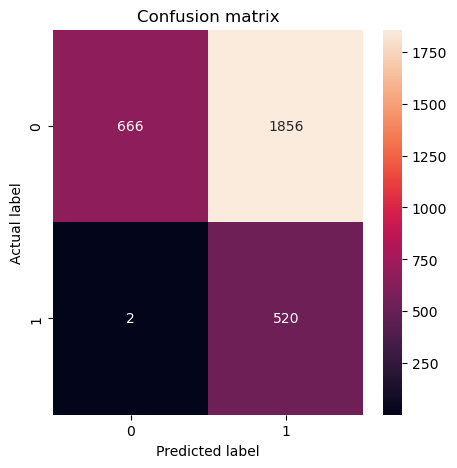

In [36]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])

y_prob = predict(mlp_with_class_weights, validset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

print('AUC score: ', roc_auc_score(y_valid, y_prob))

y_pred = (y_prob > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_valid, y_pred)

AUC score:  0.8414392113434522
(True Negatives):  1394
(False Positives):  4024
(False Negatives):  8
(True Positives):  1097
Total subscribed Transactions:  1105
total loss from loss matrix: 4176


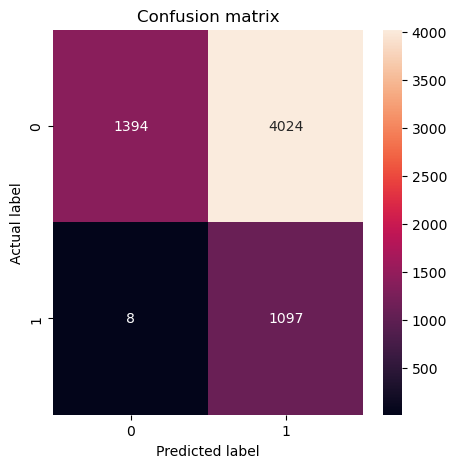

In [37]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])

y_prob = predict(mlp_with_class_weights, testset[:][0]).numpy()

y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

print('AUC score: ', roc_auc_score(y_test, y_prob))

y_pred = (y_prob > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_test, y_pred)